In [ ]:
# Simulate DCE-MRI data and use it to train DCE-Qnet network 
# Ouri Cohen 2024 (coheno1@mskcc.org)

import DCE
import numpy as np
from pyDOE import lhs

In [13]:
# define the acquisition parameters 
num_frames = 60
acquisition_params = {}
acquisition_params['schedule_length'] = num_frames
acquisition_params['FA']=np.array([12]) # deg
acquisition_params['TR']=np.array([3.4]) # ms
acquisition_params['TE']=np.array([3.22]) # ms
acquisition_params['delta_t'] = 5 # sec
acquisition_params['r1'] = 4.1 #mM^-1 s^-1
acquisition_params['model_name'] = 'tofts'

# define number of training samples 
num_training_samples = 1000

# define the tissue parameter limits
param_limits = {'Ktrans': [0,0.5], # 1/min
                'vp': [0, 0.7],
                've': [0, 0.8], 
                'T1': [0, 3000], #ms
                'BAT': [4,35], # time samples
                'B1': [0, 2], # a.u.    
}

samples = lhs(len(param_limits.keys()), samples=num_training_samples)

tissue_dict = {}
for ind, key in enumerate(param_limits.keys()):     
    min_range = min(param_limits[key])
    max_range = max(param_limits[key])
    tissue_dict[key] = min_range + (max_range - min_range) * samples[:,ind]

# convert to array
tissue_array = np.array(list(tissue_dict.values()))

# rescale 
scaling_factors = 2*np.max(tissue_array,axis=1)
tissue_array = tissue_array/scaling_factors[:,None]


In [14]:
# Simulate the DCE signals 
dce_data = DCE.DCE(tissue_dict,acquisition_params)
dce_signals = dce_data.run_sequence()

# normalize the signals
norms = [np.linalg.norm(dce_signals[:,ii]) for ii in range(dce_signals.shape[1])]        
dce_signals_normed = dce_signals/norms


In [15]:
# Neural network definition
import torch
import torch.nn as nn 

class NeuralNet(nn.Module):
    def __init__(self, inputDim=60, hiddenDim=300, outputDim=6,num_layers=5):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(NeuralNet, self).__init__()

        self.num_layers = num_layers

        self.input= nn.Linear(inputDim, hiddenDim )
        self.middle = nn.Linear(hiddenDim,hiddenDim)
        self.output= nn.Linear(hiddenDim, outputDim)

    def forward(self, x):
        """
        Build the forward pass of the network. All layers except for the output layer
        have a tanh activation function. The output layer has a sigmoid activation. 
        """
        
        currLayer= self.input(x).tanh()        
        
        for _ in range(self.num_layers):
            currLayer = self.middle(currLayer).tanh()            

        currLayer= self.output(currLayer).sigmoid()        
        return currLayer

In [16]:
# Define Dataset class
import torch.utils.data as dat

# define dataset class
# inherit abstract class Dataset and override __init__, __len__, __getitem__
class DCEDataset(dat.Dataset):    
    def __init__(self, dce_input, parameter_output, scaling_factors):        
        self.training_input = torch.Tensor(dce_input)                    
        self.training_target = torch.Tensor(parameter_output)
        self.training_scaling = torch.Tensor(scaling_factors)
      
    def __len__(self):
        # returns total number of samples        
        return self.training_input.shape[1] 
    
    def __getitem__(self, idx):
        # create an input and target sample for the current index and return it
        input_sample = self.training_input[:,idx]
        target_sample = self.training_target[:,idx]
        scaling_sample = self.training_scaling
        sample = {'input': input_sample, 'target': target_sample, 'scaling': scaling_factors}

        return sample

Text(0, 0.5, 'loss')

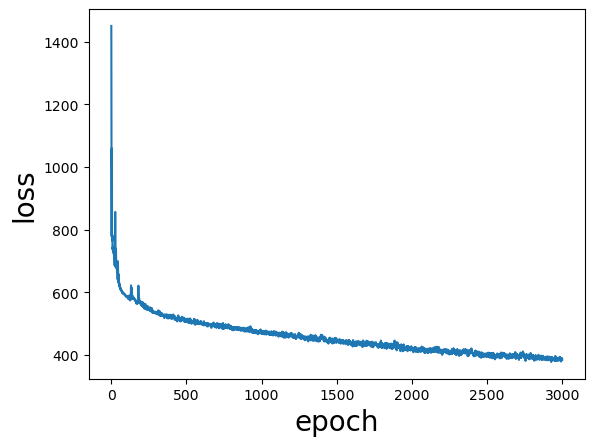

In [19]:
import matplotlib.pyplot as plt

# Train the network 
dce_dataset = DCEDataset(dce_signals_normed, tissue_array, scaling_factors)
train_loader = torch.utils.data.DataLoader(dce_dataset, batch_size=1000, shuffle=True,pin_memory=True,pin_memory_device='cuda')
model = NeuralNet(60, 300, 6, 5).cuda() 
loss = nn.L1Loss(reduction='sum') 
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.999, threshold=1e-4,min_lr=1e-4, patience=1e-4,verbose=True)   

iterations = 0
# set model to training 
model.train() 

epochs = 3000
total_batch_loss = 0
epoch_loss = []
for epoch in range(epochs):                            
    total_batch_loss = 0
    for batch_idx, batch_data in enumerate(train_loader):                
        
        optimizer.zero_grad()
        
        iterations +=1                                                    
                
        # forward pass
        # noise injection
        noise = torch.normal(mean=0.0*batch_data['input'].cuda(), std=0.02)
        batch_data['input'] = batch_data['input'].cuda() + noise                 
        
        batch_output = model(batch_data['input'].float().cuda())

        batch_loss = loss(batch_output,batch_data['target'].float().cuda())
                                    
        # do backward pass, update the weights
        batch_loss.backward()
        optimizer.step()            
        total_batch_loss += batch_loss
    
    epoch_loss.append(total_batch_loss.item())

# Save optimal model parameters in checkpoint
checkpoint = {'model_state_dict': model.state_dict(),
                    'scaling':scaling_factors,                    
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss    
                }                
                
torch.save(checkpoint, 'checkpoint')

plt.figure()
plt.plot(epoch_loss)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)

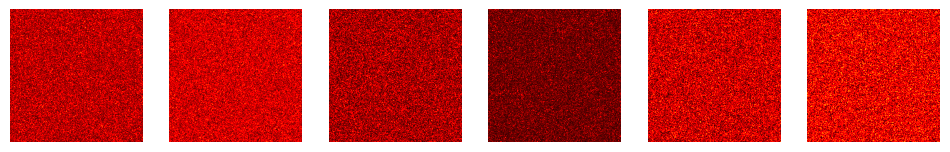

In [10]:
# Use the trained model on measured DCE-MRI data 
# we illustrate the use using a random array with a 256x256 image with 60 time points
measured_data = np.random.rand(60, 256*256)
scaling_factors = torch.Tensor(scaling_factors).cuda()

# normalize the measured data 
norms = [np.linalg.norm(measured_data[:,ii]) for ii in range(measured_data.shape[1])]        
measured_data_normed = measured_data/norms

# reshape 
measured_data_normed = torch.Tensor(measured_data_normed).T

recon_tissue_parameters = model(measured_data_normed.float().cuda())

# re-scale the parameters to actual units 
recon_tissue_parameters_rescaled = recon_tissue_parameters*scaling_factors

# reshape to an image and display 
final_imgs = np.reshape(recon_tissue_parameters_rescaled.cpu().detach().numpy(), (256,256,6))

fig, axes = plt.subplots(1, 6, figsize=(12, 12))  
axes = axes.flatten()
for ii in range(6):
    axes[ii].imshow(final_imgs[:,:,ii], cmap='hot')      
    axes[ii].axis('off')  # Hide the axes
